In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
import time
import pathlib

curr_dir = pathlib.Path(".")
data_dir = curr_dir / "IEEE-RTS-GMLC" / "RTS_Data"

In [2]:
# Read in data for IEEE RTS GMLC (Reliability Test System)
df_bus = pd.read_csv(data_dir / "SourceData" / "bus.csv", index_col=[0])
df_line = pd.read_csv(data_dir / "SourceData" / "branch.csv", index_col=[0])
df_gen_full = pd.read_csv(data_dir / "SourceData" / "gen.csv", index_col=[0])
df_ts_pointer = pd.read_csv(data_dir / "SourceData" / "timeseries_pointers.csv")

In [9]:
df_geodata = df_bus[["lat", "lng"]]

In [4]:
# Select unit types
unit_types = ["CT", "STEAM", "CC", "NUCLEAR", "PV", "RTPV", "WIND", "STORAGE"]

# Select columns
columns = ["Bus ID", "Unit Type", "Category", "Fuel", "Fuel Price $/MMBTU", "HR_avg_0", "VOM", "PMax MW", "PMin MW", "Ramp Rate MW/Min", "FOR", "Storage Roundtrip Efficiency"]

# Get final resource input data
df_gen = df_gen_full.loc[df_gen_full["Unit Type"].isin(unit_types), columns]

# Increase capacity
print(df_gen_full["PMax MW"].sum() - df_gen["PMax MW"].sum())

# # Increase capacity of renewables + storage to account for missing hydro, concentrating solar power
df_gen.loc[df_gen["Unit Type"] == "PV", "PMax MW"] += 600 / len(df_gen.loc[df_gen["Unit Type"] == "PV"])
df_gen.loc[df_gen["Unit Type"] == "STORAGE", "PMax MW"] += 600 / len(df_gen.loc[df_gen["Unit Type"] == "STORAGE"])

# Increase capacity
print(df_gen_full["PMax MW"].sum() - df_gen["PMax MW"].sum())

1200.0
0.0


In [16]:
df_gen["Unit Type"].unique()

array(['CT', 'STEAM', 'CC', 'NUCLEAR', 'PV', 'RTPV', 'WIND', 'STORAGE'],
      dtype=object)

In [10]:
df_geodata

,lat,lng
Bus ID,,
101,33.396103,-113.835642
102,33.357678,-113.825933
103,33.536833,-114.670399
104,33.812304,-113.825419
105,33.659560,-113.999023
...,...,...
321,35.745344,-117.115363
322,36.438958,-117.485272
323,34.253003,-117.113221


In [19]:
df_geodata.loc[df_gen.loc[df_gen["Unit Type"].isin(["PV", "RTPV"]), "Bus ID"].values].drop_duplicates(["lat", "lng"])

,lat,lng
Bus ID,,
320,34.462466,-117.063508
314,34.944964,-117.684879
313,34.265268,-118.018855
310,34.729316,-118.104525
324,35.206582,-118.034817
312,34.722963,-118.119887
113,34.354280,-114.274657
319,34.917631,-117.124420
215,35.148591,-114.575774


In [4]:
# Object Oriented CVXPY Model

T = 24 # Time window of optimization model(s)

### NODE ###

class Component:

    def __init__(self):
        pass

    def create_parameters(self):
        pass

    def update_timeseries_parameters(self, date):
        pass

    def create_variables(self):
        pass

    def create_expressions(self):
        pass

class Node(Component):

    def __init__(self, name, data):

        super().__init__()

        self.name = name
        self.data = data

        # Unpack node attributes from data
        self.peak_load = data["MW Load"]
        self.node_type = data["Bus Type"]
        self.lat = data["lat"]
        self.long = data["lng"]
        self.area = data["Area"]
        self.sub_area = data["Sub Area"]
        self.zone = data["Zone"]

        # Set other, generic attributes
        self.VOLL = 1e4 # $/MWh of unserved energy
        self.theta_max = np.deg2rad(30) # 30 degree maximum voltage angle

        # Initialize resources
        self.resources = []

        # Initialize in/out lines
        self.in_lines = []
        self.out_lines = []

        # Initialize load
        self.load_profile = None

    @classmethod
    def from_series(cls, df: pd.Series):
        return cls(df.name, df)

    def get_load_profile(self, ts_pointer):
        # Open / store load profile for object (can definitely make this more efficient)
        ts_rel_path = ts_pointer.loc[
            (ts_pointer.Simulation == "REAL_TIME") &
            (ts_pointer.Parameter == "MW Load") & 
            (ts_pointer.Object == str(self.area)),
            "Data File"
        ].values[0].strip("..") # Get path to load profile from time series pointer
        ts_path = pathlib.Path(str(data_dir) + ts_rel_path)
        df_load = pd.read_csv(ts_path) # Read in load data
        df_load = df_load.loc[::12, str(self.area)] # Convert to hourly
        df_load /= df_load.max() # Normalize
        df_load.index = pd.date_range(start="2020-01-01 00:00:00", end="2020-12-31 23:59:59", freq="h") # Add timeseries index
        self.load_profile = df_load

    def create_parameters(self):
        self.load = cp.Parameter(T)

    def update_timeseries_parameters(self, date: pd.Timestamp):
        self.load.value = self.peak_load * self.load_profile.loc[date:date + pd.Timedelta(hours=T-1)].values

    def create_variables(self):
        self.unserved_energy = cp.Variable(T, nonneg=True)
        self.theta = cp.Variable(T)

    def write_constraints(self):
        constraints = [
            cp.sum([r.p_out for r in self.resources]) # Nodal generation
            + cp.sum([l.flow for l in self.in_lines]) # + line inflows
            - cp.sum([l.flow for l in self.out_lines]) # - line outflows
            >= self.load - self.unserved_energy, # = load minus unserved energy (power balance constraint)
            self.unserved_energy <= self.load, # Limit unserved energy
            self.theta <= self.theta_max, self.theta >= -self.theta_max # Voltage angle limits
        ]
        self.power_balance_constraint = constraints[0]
        if self.node_type == "Ref":
            constraints += [self.theta == 0.0]
        return constraints
        
### LINE ###

class Line(Component):

    def __init__(self, name, data):

        super().__init__()

        self.name = name
        self.data = data

        # Unpack line attributes from data
        self.from_node_ID = data["From Bus"]
        self.to_node_ID = data["To Bus"]
        self.max_flow = data["LTE Rating"] # Long-term flow limit; alternatively can use continuous or short-term limits
        self.X = data["X"] # Line susceptance # MVA base = 100?

        # Initialize other parameters
        self.baseMVA = 100.0

        # Initialize from node / to node
        self.from_node = None
        self.to_node = None

    @classmethod
    def from_series(cls, df: pd.Series):
        return cls(df.name, df)

    def link_nodes(self, nodes: dict):
        # Link nodes to line
        self.from_node = nodes[self.from_node_ID]
        self.to_node = nodes[self.to_node_ID]
        # Link line to nodes
        nodes[self.from_node_ID].out_lines.append(self)
        nodes[self.to_node_ID].in_lines.append(self)
    
    def create_variables(self):
        self.flow = cp.Variable(T)

    def write_constraints(self):
        return [
            self.flow <= self.max_flow,
            self.flow >= -self.max_flow,
            self.flow == (1 / self.X) * self.baseMVA * (self.from_node.theta - self.to_node.theta)
        ]

### RESOURCES ###

class Resource(Component):

    def __init__(self, name, data):

        super().__init__()

        self.name = name
        self.data = data

        # Unpack basic resource attributes from data
        self.node_ID = data["Bus ID"] # Bus ID
        self.unit_type = data["Unit Type"] # Unit type
        self.pmax = data["PMax MW"] # Nameplate capacity (MW)
        self.VOM = data["VOM"] # Variable O&M costs ($/MWh)

        # Initialize node
        self.node = None

    @classmethod
    def from_series(cls, df: pd.Series):
        return cls(df.name, df)

    def link_node(self, nodes: dict):
        # Link node to resource
        self.node = nodes[self.node_ID]
        # Link resource to node
        nodes[self.node_ID].resources.append(self)

    def create_variables(self):
        self.p_out = cp.Variable(T, nonneg=True)

    def write_constraints(self):
        return [self.p_out <= self.pmax]

class ThermalResource(Resource):

    def __init__(self, name, data):
        
        super().__init__(name, data)

        # Unpack thermal resource attributes from data
        
        # Cost attributes
        self.fuel_price = data["Fuel Price $/MMBTU"]
        self.heat_rate = data["HR_avg_0"] / 1000 # BTU/kWh --> MMBTU/MWh
        self.variable_costs = self.fuel_price * self.heat_rate + self.VOM
        
        # Operational attributes
        self.pmin = data["PMin MW"] # Minimum output (for unit commitment
        self.ramp_rate = 60 * data["Ramp Rate MW/Min"]
        self.FOR = data["FOR"]

class VariableResource(Resource):

    def __init__(self, name, data):

        super().__init__(name, data)

        # Cost attributes
        self.variable_costs = self.VOM

        # Operational attributes
        self.nameplate_capacity = data["PMax MW"]

        # Initialize generation profile
        self.gen_profile = None

    def get_gen_profile(self, ts_pointer):
        ts_rel_path = ts_pointer.loc[
            (ts_pointer.Simulation == "REAL_TIME") &
            (ts_pointer.Parameter == "PMax MW") & 
            (ts_pointer.Object == self.name),
            "Data File"
        ].values[0].strip("..") # Get path to profile from time series pointer
        ts_path = pathlib.Path(str(data_dir) + ts_rel_path)
        df_profile = pd.read_csv(ts_path) # Read in data
        df_profile = df_profile.loc[::12, self.name] # Convert to hourly
        df_profile /= df_profile.max() # Normalize
        df_profile.index = pd.date_range(start="2020-01-01 00:00:00", end="2020-12-31 23:59:59", freq="h") # Add timeseries index
        self.gen_profile = df_profile

    def create_parameters(self):
        self.pmax = cp.Parameter(T)

    def update_timeseries_parameters(self, date: pd.Timestamp):
        self.pmax.value = self.nameplate_capacity * self.gen_profile.loc[date:date + pd.Timedelta(hours=T-1)].values

class StorageResource(Resource):

    def __init__(self, name, data, duration=4):

        super().__init__(name, data)

        # Cost attributes
        self.variable_costs = self.VOM

        # Operational attributes
        self.duration = duration
        self.max_SOC = self.pmax * self.duration
        self.efficiency = data["Storage Roundtrip Efficiency"]

    def create_variables(self):
        self.charge = cp.Variable(T, nonneg=True)
        self.discharge = cp.Variable(T, nonneg=True)
        self.SOC = cp.Variable(T, nonneg=True)

    def create_expressions(self):
        self.p_out = self.discharge - self.charge

    def write_constraints(self):
        constraints = [
            self.charge <= self.pmax,
            self.discharge <= self.pmax,
            self.SOC <= self.max_SOC
        ]
        constraints += [
            self.SOC[t] == self.SOC[np.mod(t-1, T)] + self.efficiency * self.charge[np.mod(t-1, T)] - self.discharge[np.mod(t-1, T)]
            for t in range(T)
        ]
        return constraints

In [5]:
### SET UP SYSTEM ###

# df_gen, df_line, df_bus, df_ts_pointer

# 1. Instantiate nodes
nodes = {}
for node in df_bus.index:
    nodes[node] = Node.from_series(df_bus.loc[node])
    nodes[node].get_load_profile(df_ts_pointer) # Read in load profile

# 2. Instantiate + link lines
lines = {}
for line in df_line.index:
    lines[line] = Line.from_series(df_line.loc[line])
    lines[line].link_nodes(nodes) # Link lines to nodes
    
# 3. Instantiate + link resources
resources = {}
thermal_resource_types = ["CT", "STEAM", "CC", "NUCLEAR"]
variable_resource_types = ["PV", "RTPV", "WIND"]
storage_resource_types = ["STORAGE"]
for resource in df_gen.index:
    unit_type = df_gen.loc[resource, "Unit Type"]
    if unit_type in thermal_resource_types:
        resources[resource] = ThermalResource.from_series(df_gen.loc[resource])
    elif unit_type in variable_resource_types:
        resources[resource] = VariableResource.from_series(df_gen.loc[resource])
        resources[resource].get_gen_profile(df_ts_pointer) # Read in generation profile
    elif unit_type in storage_resource_types:
        resources[resource] = StorageResource.from_series(df_gen.loc[resource])
    resources[resource].link_node(nodes) # Link resource to node

In [6]:
# Create list of components
components = list(nodes.values()) + list(lines.values()) + list(resources.values())

# Select date
date = pd.Timestamp(year=2020, month=3, day=20).date()

### Parameters, Variables, Expressions ###

# Create parameters, variables, and expressions for all objects
for obj in components:
    obj.create_parameters()
    obj.create_variables()
    obj.create_expressions()

### Constraints ###

# Write constraints for all system components
constraints = []
for obj in list(nodes.values()) + list(lines.values()) + list(resources.values()):
    constraints += obj.write_constraints()

# Write system load balance constraint
#constraints += [cp.sum([r.p_out for r in resources.values()]) == cp.sum([n.load - n.unserved_energy for n in nodes.values()])] # System load balance constraint

### Objective Function ###

# Get total system variable costs
total_variable_costs = cp.sum(cp.sum([cp.multiply(r.variable_costs, r.p_out) for r in resources.values()]))
total_unserved_energy_costs = cp.sum(cp.sum([n.VOLL * n.unserved_energy for n in nodes.values()]))
total_cost = total_variable_costs + total_unserved_energy_costs # + startup costs + ... etc.

### Problem ###
prob = cp.Problem(cp.Minimize(total_cost), constraints)

In [7]:
### LOLP Simulation ###

# Simulate each day in data set
df_results = pd.DataFrame(index=pd.date_range("2020-01-01 00:00:00", "2020-12-31 23:59:59", freq="h"), columns=["Cost", "Unserved Energy"])
df_LMP = pd.DataFrame(index=df_results.index, columns=list(nodes.keys()))
start = time.time()
for date in df_results.index[::T]:
    if date + pd.Timedelta(hours=T) > df_results.index.max():
        break
    
    # Update time series parameters
    for obj in components:
        obj.update_timeseries_parameters(date)
    
    # Solve model
    result = prob.solve(solver=cp.GUROBI)
    
    # Save results
    df_results.loc[date, "Cost"] = total_variable_costs.value
    df_results.loc[date, "Unserved Energy"] = cp.sum(cp.sum([n.unserved_energy for n in nodes.values()])).value
    for n in nodes.keys():
        df_LMP.loc[date:date + pd.Timedelta(hours=T-1), n] = nodes[n].power_balance_constraint.dual_value
        
end = time.time()
time_elapsed = end - start
print(f"Total Elapsed Time: {time_elapsed:.1f}s")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-25
Total Elapsed Time: 47.0s


<Axes: >

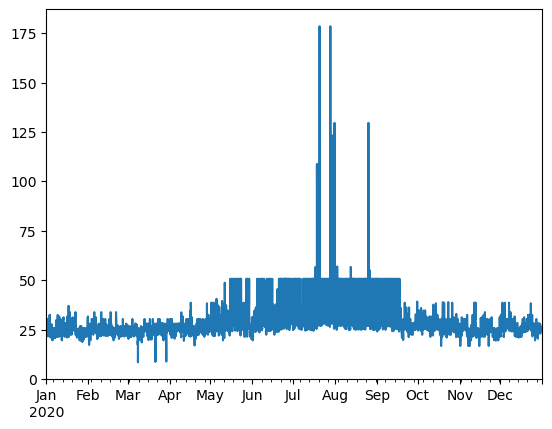

In [14]:
df_LMP[df_LMP.max(axis=0).idxmax()].plot()

In [16]:
len(nodes)

73